# 7.1 Sequential 모델을 넘어서: 케라스의 함수형 API
- 지금까지는 `Sequential` 모델을 사용하여 만듦 : 네트워크 입력과 출력이 하나라고 가정, 층을 차례대로 쌓아 구성
- 대부분이 이런 가정이 적절하지만 일부는 개별 입력이 여러 개 필요하거나 출력이 여러 개 필요하며 층을 차례대로 쌓지 않고 층 사이를 연결하여 그래프로 연결하기도함
    - 다중 입력 모델 : 완전 연결 모델(메타데이터) + RNN 모듈(텍스트 설명) + 컨브넷 모듈(사진)을 동시에 입력으로 받아 값을 예측하는 것
        - 각 모델을 만들어 가중 평균(weighted average)하는 방법도 있으나 각 모델에서 추출한 정보가 중복된다면 최적이 아님
    - 다중 출력 모델 : 텍스트로 1. 장르를 예측, 2. 쓰여진 연대를 예측
        - 장르와 시대 사이의 상관관계 때문에 소설 시대를 알면 장르의 공간에서 정확하고 풍부한 표현을 학습하는 데 도움이 됨(반대도 마찬가지)
    - **인셉션** 모듈 : 나란히 놓인 합성곱 층으로 구성된 서브그래프 (구글의 세게디 등이 개발)
    - **잔차 연결** : 하위 층의 출력을 상위 층의 특성 맵에 더함 (마이크로소프트의 허(He) 등이 개발)
        - ResNet 계열의 네트워크가 이런 방식을 사용하며, 아래층의 표현이 네트워크 위쪽으로 흘러갈 수 있도록 하여 하위 층에서 학습된 정보가 데이터 처리 과정에서 손실되는 것을 방지
- 이런 것들을 **함수형 API**를 통하여 만들 수 있음

## 7.1.1 함수형 API 소개
- 함수처럼 층을 사용하여 텐서를 입력받고 출력함

In [1]:
from tensorflow.keras import Input, layers

# 텐서
input_tensor = Input(shape=(32,))

# 함수처럼 사용하기 위해 층 객체를 만듦
dense = layers.Dense(32, activation='relu')

# 텐서와 함께 층을 호출하면 텐서를 반환함
output_tensor = dense(input_tensor) # dense.__call__(input_tensor)와 같음

### `Sequential` 모델 예시

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


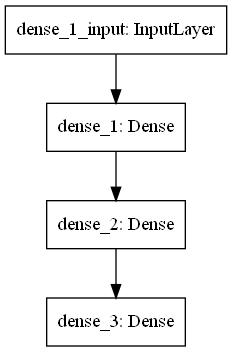

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(seq_model)

### 함수형 API 모델 예시

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input

input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


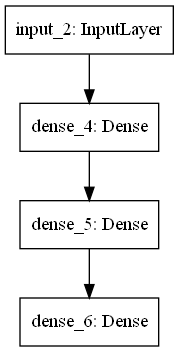

In [5]:
plot_model(model)

### 실패한 모델 예시
- 관련되지 않은 입력과 출력으로 모델을 만들면 `RuntimeError` 발생
- 출력 텐서에서 `input_1` 텐서로 다다를 수 없다는 뜻

In [3]:
unrelated_input = Input(shape=(32,))
bad_model = Model(unrelated_input, output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "dense_3". The following previous layers were accessed without issue: []

### `Model` 객체 컴파일, 훈련, 평가
- `Sequential` 클래스와 같음

In [6]:
# 모델 컴파일
model.compile(optimizer='rmsprop',loss='categorical_crossentropy')

# 훈련을 위해 랜덤한 넘파이 데이터 생성
import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))

# 모델 훈련
model.fit(x_train, y_train, epochs=10, batch_size=128)

# 모델 평가
score = model.evaluate(x_train, y_train)

Epoch 1/10
8/8 [==============================] - 1s 3ms/step - loss: 11.9260
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 12.6405
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 13.6158
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 14.9909
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 16.6169
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 18.3937
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 20.2300
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 22.2128
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 24.3987
Epoch 10/10
32/32 [==============================] - 0s 1ms/step - loss: 28.2491


## 7.1.2 다중 입력 모델
- 서로 다른 입력 가지를 합치기 위해 `keras.layers.add`, `keras.layers.concatenate` 등을 사용
    - 이외에도 `layers.average()`, `layers.maximum()`, `layers.minimum()`, `layers.multiply()`, `layers.subtract()`, `layers.dot()` 등이 있음
- 질문-응답 모델 : 2개의 입력을 가짐
    - 자연어 질문과 답변에 필요한 정보가 담겨 있는 텍스트를 주고 답을 출력하는 모델
    - 가장 간단한 구조는 미리 정의한 어휘 사전에서 소프트맥스 함수를 통해 한 단어로 된 답을 출력하는 것

### 2개의 입력을 가진 질문-응답 모델의 함수형 API 구현하기
- 텍스트와 질문을 벡터로 인코딩하여 독립된 입력 2개를 정의
- 이 벡터를 연결하고 그 위에 소프트맥스 분류기를 추가

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 텍스트 입력 : 길이가 정해지지 않은 정수 시퀀스
text_input = Input(shape=(None,), dtype='int32', name='text')

# 입력을 크기가 64인 벡터의 시퀀스로 임베딩
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)

# LSTM을 사용하여 이 벡터들을 하나의 벡터로 인코딩
encoded_text = layers.LSTM(32)(embedded_text)



# 질문도 같은 과정을 거침
question_input = Input(shape=(None,), dtype='int32', name='question')

embedded_question = layers.Embedding(question_vocabulary_size, 32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)


# 인코딩된 질문과 텍스트를 연결
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)

# 소프트맥스 분류기 추가
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)

# 모델 객체를 만들고 2개의 입력과 하나의 출력을 주입
model = Model([text_input, question_input], answer)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     320000      question[0][0]                   
____________________________________________________________________________________________

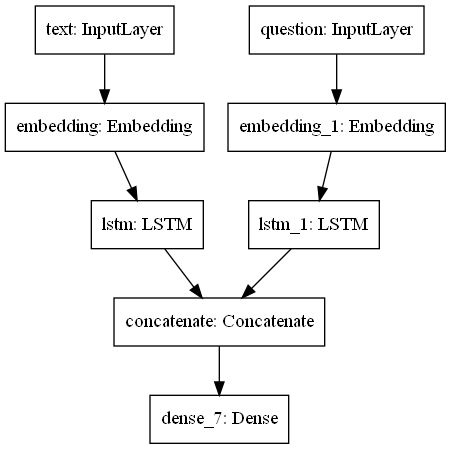

In [9]:
plot_model(model)

### 다중 입력 모델에 데이터 주입하기
- 넘파이 배열의 리스트를 주입
- 또는 입력 이름과 넘파이 배열로 이루어진 딕셔너리를 주입(입력 이름을 설정했을 때 가능)

In [7]:
import numpy as np
from tensorflow.keras.utils import to_categorical

num_samples = 1000
max_length = 100

# 랜덤한 넘파이 데이터 생성
text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))

answers = np.random.randint(0, answer_vocabulary_size, size=num_samples)

# 답은 정수가 아닌 원-핫 인코딩된 벡터
answers = to_categorical(answers)

In [ ]:
# 리스트 입력을 사용하여 학습
model.fit([text, question], answers, epochs=10, batch_size=128)

In [8]:
# 딕셔너리 입력을 사용하여 학습
model.fit({'text':text, 'question':question}, answers, epochs=10, batch_size=128)

Epoch 1/10
8/8 [==============================] - 6s 14ms/step - loss: 6.2143 - accuracy: 0.0020
Epoch 2/10
8/8 [==============================] - 0s 14ms/step - loss: 6.1942 - accuracy: 0.0430
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 6.1222 - accuracy: 0.0050
Epoch 4/10
8/8 [==============================] - 0s 12ms/step - loss: 6.0483 - accuracy: 0.0050
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 5.9790 - accuracy: 0.0100
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 5.9100 - accuracy: 0.0100
Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 5.8417 - accuracy: 0.0130
Epoch 8/10
8/8 [==============================] - 0s 13ms/step - loss: 5.7717 - accuracy: 0.0140
Epoch 9/10
8/8 [==============================] - 0s 12ms/step - loss: 5.7015 - accuracy: 0.0230
Epoch 10/10
8/8 [==============================] - 0s 12ms/step - loss: 5.6221 - accuracy: 0.0300


## 7.1.3 다중 출력 모델
- 소셜 미디어에서 익명 사용자의 포스트를 입력으로 받아 나이, 성별, 소득 수준 등을 예측하는 예제

### 3개의 출력을 가진 함수형 API 구현하기

In [10]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size, 256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 출력 층에 이름을 지정
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups,
                                 activation='softmax',
                                 name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input,
              [age_prediction, income_prediction, gender_prediction])

In [11]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    163968      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 128)    0           conv1d[0][0]                     
____________________________________________________________________________________________

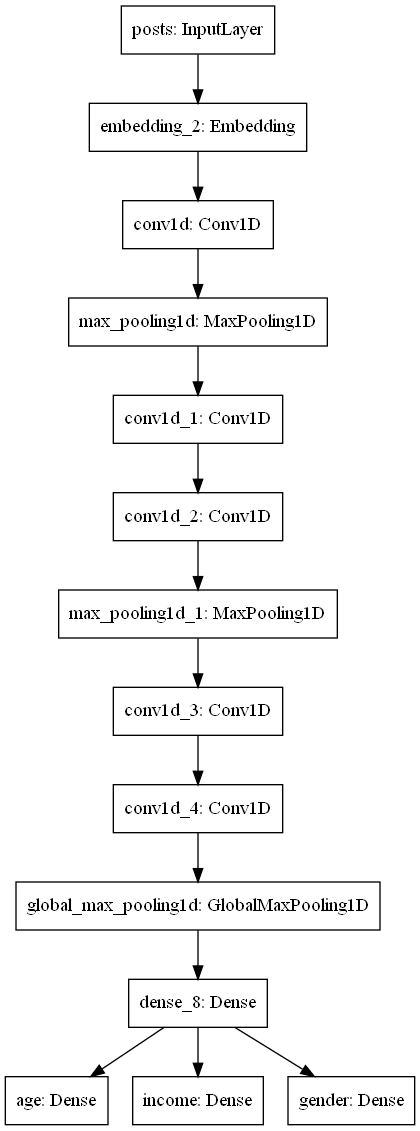

In [12]:
plot_model(model)

### 다중 출력 모델의 컴파일 옵션: 다중 손실
- 네트워크 출력마다 다른 손실 함수를 지정해야 함
- 경사하강법은 하나의 스칼라 값을 최소화하기 때문에 모델을 훈련하려면 여러 손실들을 하나의 값으로 합쳐야 함(모두 더함)

In [ ]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# 출력에 이름을 지정했을 경우
model.compile(optimizer='rmsprop',
              loss={'age':'mse',
                    'income':'categorical_crossentropy',
                    'gender':'binary_crossentropy'})

### 다중 출력 모델의 컴파일 옵션: 손실 가중치
- 손실 값이 불균형하면 모델이 개별 손실이 가장 큰 작업에 치우쳐 표현을 최적화하여 다른 작업들은 손해를 입음
- 이를 해결하기 위하여 가중치를 줌

In [ ]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.])

# 출력에 이름을 지정했을 경우
model.compile(optimizer='rmsprop',
              loss={'age':'mse',
                    'income':'categorical_crossentropy',
                    'gender':'binary_crossentropy'},
              loss_weights={'age':0.25,
                            'income':1.,
                            'gender':10.})

### 다중 출력 모델에 데이터 주입하기
- 다중 입력 모델과 마찬가지로 넘파이 배열의 리스트나 딕셔너리를 모델에 전달하여 훈련

In [ ]:
model.fit(posts, [age_targets, income_targets, gender_targets],
          epochs=10, batch_size=64)

# 출력에 이름을 지정했을 경우
model.fit(posts, {'age':age_targets,
                  'income':income_targets,
                  'gender':gender_targets},
          epochs=10, batch_size=64)

## 7.1.4 층으로 구성된 비순환 유향 그래프
- **비순환 유향 그래프**(directed acyclic graph) : 텐서 x가 자기 자신을 출력하는 층의 입력이 될 수 없음
- 가장 유명한 것은 인셉션 모듈과 잔차 연결

### 인셉션 모듈
- **인셉션**(Inception) : 합성곱 신경망
    - **네트워크 안의 네트워크**(network-in-network) 구조에서 영감을 받아 2013~2014년 크리스티안 세게디(Christian Szegedy)와 구글 동료가 개발
    - 나란히 분리된 가지를 따라 모듈을 쌓아 독립된 작은 네트워크처럼 구성
    - 1x1 합성곱으로 시작해서 3x3 합성곱, 마지막에 전체 출력 특성이 합쳐짐
    - 네트워크가 따로따로 공간 특성과 채널 방향의 특성을 합성하도록 하여 한꺼번에 학습하는 것보다 효과가 더 높음
- 더 복잡한 인셉션 모듈은 풀링 연산, 여러 가지 합성곱 사이즈(3x3만이 아닌 5x5 등), 공간 합성곱이 없는 가지(1x1 합성곱)로 구성

### 1x1 합성곱의 목적
- 모든 타일 벡터를 하나의 `Dense` 층에 통과시키는 것과 동일하여 입력 텐서의 채널 정보를 혼합한 특성을 계산함
- 공간 방향으로는 정보를 섞지 않으므로 채널 방향의 특성 학습과 공간 방향의 특성 학습을 분리하는 데 도움을 줌
- 채널이 공간 방향으로 상관관계가 크고 채널 간에는 독립적이라고 가정하는 경우 좋은 방법임

### 인셉션 모듈(인셉션 V3) 구현 예시
- 이 구현 예에서 4개의 가지가 출력하는 텐서의 크기가 조금씩 다르므로 `padding=same` 옵션을 주어 크기를 맞추어 주어야함

In [ ]:
from tensorflow.keras import layers

# 모든 가지는 동일한 스트라이드(2)를 사용 - 출력 크기를 동일하게 만들어 하나로 합치기 위함
branch_a = layers.Conv2D(128, 1, activation='relu', strides=2)(x)

# 이 가지는 두 번째 합성곱 층에서 스트라이드를 적용
branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

# 이 가지는 평균 풀링 층에서 스트라이드를 적용
branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 3, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_d)

# 모든 가지의 출력을 연결하여 모듈의 출력을 만듦
output = layers.concatenate(
    [branch_a, branch_b, branch_c, branch_d], axis=-1)

### 인셉션 모델 전체 구조

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

model = InceptionV3()

96124928/96112376 [==============================] - 6s 0us/step


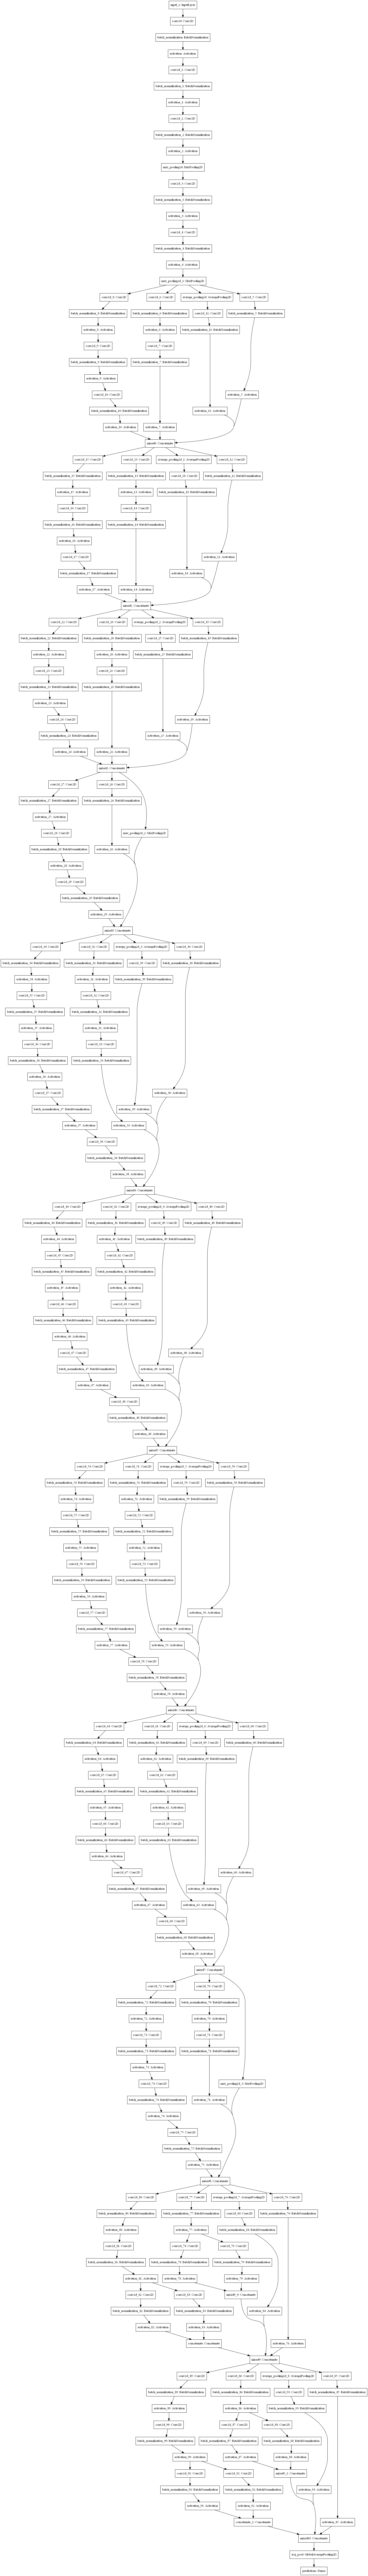

In [2]:
from tensorflow.keras.utils import plot_model

plot_model(model)

- 비슷한 모델인 **엑셉션**(Xception)도 케라스에 포함되어 있음
    - 극단적인 인셉션으로, 깊이별 합성곱(depthwise convolution)(각 입력 체널에 따로따로 적용되는 공간 방향 합성곱) 다음에 점별 합성곱(1x1 합성곱)이 뛰따름
    - 공간 특성과 채널 방향 특성을 완전히 분리함
- 인셉션 모델보다 실행 속도가 더 빠르고 대규모 데이터셋에서 정확도가 더 높음
- `from tensorflow.keras.application.xception import Xception`

### 잔차 연결
- **잔차 연결**(residual connection) : 대규모 딥러닝 모델에서 흔히 나타나는 그래디언트 소실과 표현 병목(representational bottleneck) 문제를 해결
- 일반적으로 10개 층 이상을 가진 모델에 잔차 연결을 추가하면 도움이 됨
- 하위 층의 출력을 상위 층의 입력으로 사용함, 그러므로 두 출력의 크기가 동일해야 함

### 잔차 연결 예시
- 입력 x가 4D 텐서라고 가정

In [ ]:
from tensorflow.keras import layers

x = ...
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# 원본 x를 출력 특성에 더함
y = layers.add([y, x])

### 잔차 연결 예시(특성 맵의 크기가 다를 때)

In [ ]:
from tensorflow.keras import layers

x = ...
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# y와 크기를 맞추기 위해 1x1 합성곱을 사용하여 원본 텐서 x를 다운샘플링
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

# 다운샘플링된 x를 출력 특성에 더함
y = layers.add([y, residual])

### 딥러닝의 표현 병목
- `Sequential` 모델에서 표현 학습을 위한 층은 다른 층위에 연달아 놓임 : 층은 이전 층의 활성화 출력 정보만 사용
- 어떤 층이 너무 작으면(저차원이면) 이 활성화 출력에 얼마나 많은 정보를 채울 수 있느냐에 모델 성능이 좌우됨
- 한 번 줄어든 연산을 복원할 수 없으나 잔차 연결은 이 이슈를 어느 정도 해결함

### 딥러닝의 그래디언트 소실 문제
- **그래디언트 소실**(vanishing gradient) 문제 : 역전파 알고리즘이 전파하는 피드백 신호가 깊이 쌓인 층을 통과하여 전파되면 신호가 아주 작아지거나 완전히 사라지는 문제
- 심층 신경망과 긴 시퀀스를 처리하는 신경망에서 나타나는 문제
- `LSTM`이 이 문제를 해결하기 위한 방법 중 하나
- 잔차 연결은 주 네트워크 층에 나란히 단순한 선형 정보를 실어 나름 : 그래디언트가 깊게 쌓은 층을 통과하여 전파하도록 도와줌
    - 잔차 연결에서 하위 층의 출력과 상위 층의 출력을 단순히 더했으므로 그래디언트가 그대로 잔차 연결을 따라 하위 층으로도 전달됨

## 7.1.5 층 가중치 공유
- 층 객체를 두 번 호출하면 새로운 층 객체를 만들지 않고 각 호출에 동일한 가중치를 재사용
- 같은 표현을 공유하고 이런 표현을 다른 입력에서 함께 학습
- A와 B의 유사도는 B와 A와 유사도와 같으므로 입력 문장을 처리하는 2개의 독립된 모델을 학습하는 것은 올바른 방법이 아님
- **샴 LSTM**(Siamese LSTM) 또는 **공유 LSTM** : 하나의 LSTM 층으로 양쪽을 모두 처리

### 함수형 API로 공유 층(재사용 층) 모델 구현 예제

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model

# LSTM 층 객체 생성
lstm = layers.LSTM(32)

# 모델의 왼쪽 가지 구성 - 입력은 크기가 128인 벡터의 가변 길이 시퀀스
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

# 모델의 오른쪽 가지 구성 - 기존 층 객체를 호출하면 가중치가 재사용됨
right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

# 맨 위에 분류기를 놓음
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# 모델 객체를 만듦
model = Model([left_input, right_input], predictions)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           20608       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64)           0           lstm[0][0]                   

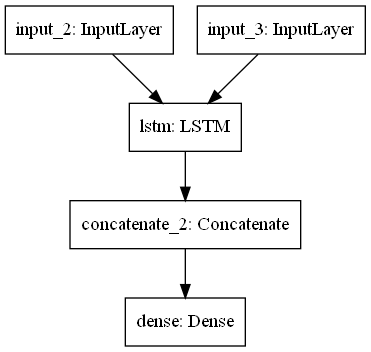

In [5]:
plot_model(model)

In [ ]:
# 훈련
# LSTM 층의 가중치는 양쪽 입력을 바탕으로 업데이트됨
model.fit([left_data, right_data], targets)

## 7.1.6 층과 모델
- 모델을 층처럼 사용할 수 있음 : 모델을 '커다란 층'으로 생각(5.3장에서 conv_base 사용한 경우와 같음)
- 입력 텐서로 모델을 호출해서 출력 텐서를 얻을 수 있음
```python
y = model(x)
```
- 모델에서 입력 텐서와 출력 텐서가 여러 개이면 텐서의 리스트로 호출
```python
y1, y2 = model([x1, x2])
```
- 모델 객체를 호출할 때 모델의 가중치가 재사용됨

### 모델 객체를 재사용하는 실전 예
- 듀얼 카메라에서 입력을 받는 비전 모델
    - 두 카메라가 몇 센티미터 간격을 두고 나란히 있음
    - 이런 모델은 깊이를 감지할 수 있음
    - 왼쪽 카메라와 오른쪽 카메라에서 시각적 특징을 추출하여 합치기 위해 2개의 독립된 모델을 사용할 필요가 없음
    - 두 입력에 저수준 처리 과정이 공유될 수 있음

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras import Input

# 이미지 처리 기본 모델 = 엑셉션 네트워크(합성곱 기반 층만 사용)
xception_base = applications.Xception(weights=None,
                                      include_top=False)

# 입력은 250x250 RGB 이미지
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

# 같은 비전 모델을 두 번 호출
left_features = xception_base(left_input)
right_features = xception_base(right_input)

# 합쳐진 특성은 오른쪽 입력과 왼쪽 입력에서 얻은 정보를 담고 있음
merged_features = layers.concatenate(
    [left_features, right_features], axis=-1)